In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import yfinance as yf

In [107]:
start_date = "1990-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
df = yf.download("NG=F", start=start_date, end=end_date)["Close"]
df.to_csv("NG=F.csv")
df

[*********************100%***********************]  1 of 1 completed


Ticker,NG=F
Date,
2000-08-30,4.805
2000-08-31,4.780
2000-09-01,4.835
2000-09-05,4.960
2000-09-06,5.065
...,...
2025-06-04,3.716
2025-06-05,3.677
2025-06-06,3.784


In [32]:
df_daily = pd.read_csv("CL=F.csv", parse_dates=["Date"]).set_index("Date").sort_index()
df_monthly = pd.read_csv("CPIENGSL.csv", parse_dates=["observation_date"]).rename({"observation_date": "Date"}, axis="columns").set_index("Date").sort_index()
df_monthly.index = df_monthly.index.to_period("M")

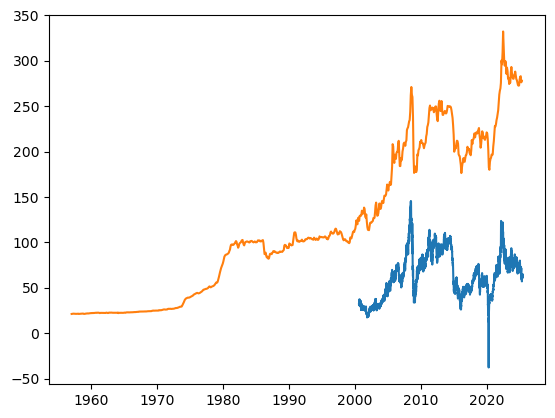

In [39]:
plt.plot(df_daily)
plt.plot(df_monthly)
plt.show()

In [40]:
daily_ret   = np.log(df_daily['CL=F']).diff().dropna() * 100
monthly_mom = df_monthly['CPIENGSL'].pct_change().dropna() * 100

daily_ret = daily_ret.asfreq('B').ffill()
monthly_ts = monthly_mom.to_timestamp('M')

daily_z   = (daily_ret   - daily_ret.mean())   / daily_ret.std(ddof=0)
monthly_z = (monthly_mom - monthly_mom.mean()) / monthly_mom.std(ddof=0)

/Users/K/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


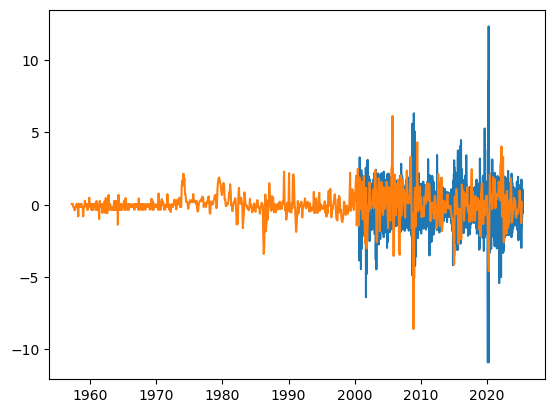

In [41]:
plt.plot(daily_z)
plt.plot(monthly_z)
plt.show()

In [42]:
idx = pd.date_range(daily_z.index.min(), daily_z.index.max(), freq='B')
daily_mat   = daily_z.reindex(idx)
monthly_mat = monthly_z.to_timestamp('M').reindex(idx)

df_daily   = daily_mat.to_frame(name='WTI_ret')
df_monthly = monthly_mat.to_frame(name='CPI_Energy_MoM')

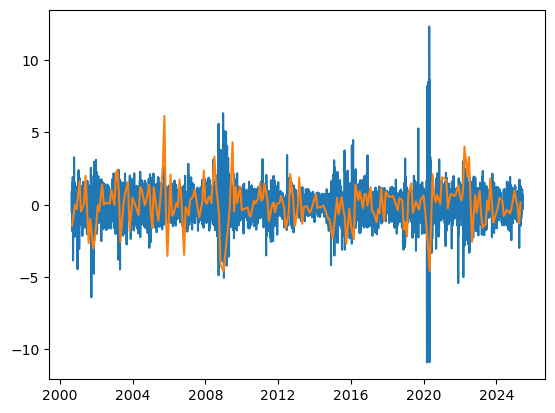

In [48]:
plt.plot(df_daily)
plt.plot(df_monthly.dropna())
plt.show()

In [66]:
"""
dynamic_factor_dm.py
--------------------
日次(D) / 月次(M) 混合頻度 Dynamic Factor Model for statsmodels.

* 先頭 k_endog_daily 列 … 日次観測 (欠損なし想定、祝日欠損は NaN で可)
* 残り          … 月次観測 (月末だけ値、ほか NaN)

元クラス: statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ
----------------------------------------------------------------------
"""

from __future__ import annotations
import calendar
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


class DynamicFactorDM(DynamicFactorMQ):
    """
    Dynamic Factor Mixed-Frequency model (Daily / Monthly version).

    Parameters
    ----------
    endog : pd.DataFrame
        日次インデックス。最初 ``k_endog_daily`` 列が日次系列、
        それ以外は月次系列 (月末のみ値、その他 NaN)。
    k_endog_daily : int
        日次系列の本数。
    factors, factor_orders, idiosyncratic_ar1, factor_multiplicative : \
        DynamicFactorMQ と同じ。
    """

    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int],
        factor_orders: int | list[int],
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        # DynamicFactorMQ の引数名は "k_endog_monthly" (=高頻度) なので
        #   → 日次列数をそのまま渡す
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # ------------------------------------------------------------------
    # ★   月次系列の「月平均」集計行列 K_t を作り直す                   ★
    # ------------------------------------------------------------------
    def _init_aggregation_matrices(self) -> None:  # noqa: N802 (元メソッド名)
        """
        Build aggregation matrix K_t for each observation t.

        月次観測は
            y_M(t_month_end) = (1/N_m) Σ_{d∈月}  f_d  + ε_t
        となるので、month ごとに N_m(=その月の日数) を変える。
        """
        # ---- 準備 -----------------------------------------------------
        idx = self._index                           # pd.DatetimeIndex (日次)
        L = max(calendar.monthrange(ts.year, ts.month)[1] for ts in idx)  # 31
        k_endog_M = self.k_endog_quarterly          # (=月次列数)
        k_states   = self.ssm.k_states              # = factors * L

        # selection マトリクス (日次観測用: 当日の因子のみ 1)
        K_daily = np.zeros((self.k_endog_monthly, k_states))
        for r in range(self.k_endog_monthly):
            K_daily[r, r * L] = 1.0                 # 先頭ラグ位置

        # ---- 各 t ごとに Z_t (design) を組み立て ----------------------
        Z_t = np.zeros((self.k_endog, k_states, len(idx)))

        # 1) 日次パート: 毎日同じ
        Z_t[: self.k_endog_monthly, :, :] = K_daily[:, :, None]

        # 2) 月次パート: 月単位で平均を取る
        pos_M = slice(self.k_endog_monthly, self.k_endog)  # 行インデックス
        month_id = idx.to_period("M")

        for t, ts in enumerate(idx):
            if np.isnan(self.endog.iloc[t, pos_M]).all():
                # 月次欠損行 → ゼロ行のまま (観測しない)
                continue

            # その月の日数と「月末からの距離 d」計算
            last_day = ts.to_period("M").to_timestamp("M")
            days_in_month = (last_day.to_period("D").end_time.to_pydatetime().day)
            # 末端ラグから 0 … -(days_in_month-1)
            lag_idx = np.arange(days_in_month)[::-1]

            # 係数 1/N_m をラグごとに配置
            row = np.zeros(k_states)
            row[lag_idx] = 1.0 / days_in_month
            Z_t[pos_M, :, t] = np.tile(row, (k_endog_M, 1))

        # statsmodels レイヤに渡す
        self.ssm['design'] = Z_t

    # ------------------------------------------------------------------
    # その他のステップは元クラスの EM / Kalman フィルタをそのまま使用。
    # ------------------------------------------------------------------


# ----------------------------------------------------------------------
# 使い方サンプル
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # シンプルサンプル：日次 ×1列 + 月次 ×1列
    import matplotlib.pyplot as plt

    np.random.seed(0)
    dates = pd.date_range("2024-01-01", "2024-12-31", freq="D")
    n = len(dates)

    f_true = np.cumsum(np.random.randn(n))
    yD = f_true + 0.1 * np.random.randn(n)

    yM = pd.Series(index=dates, dtype=float)
    for ts, v in pd.Series(f_true, index=dates).resample("M").mean().items():
        yM.loc[ts] = v + 0.2 * np.random.randn()

    df = pd.DataFrame({"yD": yD, "yM": yM})

    mod = DynamicFactorDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    #plt.plot(res.factors.smoothed.iloc[:, 0], label="Smoothed factor")
    #plt.plot(dates, f_true, "--", label="True factor")
    #plt.legend(); plt.title("DynamicFactorDM result"); plt.show()


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['factor_multiplicative']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


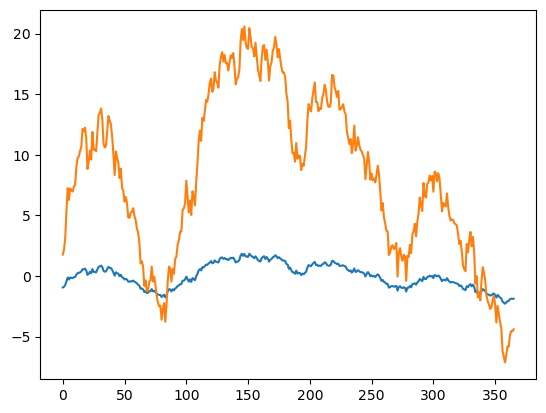

In [71]:
plt.plot(res.factors.smoothed.iloc[:, 0].values)
plt.plot(f_true)
plt.show()

In [72]:
fitted = res.predict()

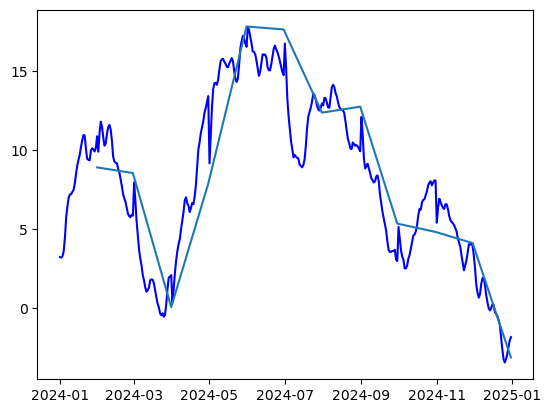

In [97]:
plt.plot(fitted.iloc[:,1], color="blue")
#plt.plot(fitted.index.values, yD, color="orange")
plt.plot(yM.dropna())
plt.show()

In [98]:
"""
dynamic_factor_dm_biz.py
------------------------
*statsmodels* 標準の **DynamicFactorMQ** を「高頻度＝日次・低頻度＝月次」に
流用するためのサブクラスと、  
**営業日ベース** の日次系列を扱う完全サンプル。

● 主なポイント
------------------------------------------------------------------
1. **週末・祝日欠損を NaN のまま** カレンダー日に再インデックス  
   → 状態ベクトル長 31 を維持し、既存アルゴリズムをそのまま利用  
2. 月次観測は「月末**営業日**」にのみ値を入れる  
3. `res.predict()` で得られるフィット値は  
   - 日次列 : in-sample fitted  
   - 月次列 : **営業日ごとのナウキャスト** （月末実測セルでは誤差 0）

------------------------------------------------------------------
動かすには
  $ pip install statsmodels pandas_market_calendars matplotlib
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import calendar
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


# ------------------------------------------------------------------
# 1. クラス定義（最小限のオーバーライド）
# ------------------------------------------------------------------
class DynamicFactorDM(DynamicFactorMQ):
    """
    Dynamic-Factor Mixed-Frequency  (Daily ↔ Monthly).

    Parameters
    ----------
    endog : pd.DataFrame
        インデックス = **連続カレンダー日**。先頭 k_endog_daily 列が日次観測、
        残りが月次観測（値は「月末営業日だけ」入れ、他は NaN）。
    k_endog_daily : int
        日次観測の本数。
    """

    # コンストラクタ: 引数名だけ読み替え
    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int] = 1,
        factor_orders: int | list[int] = 1,
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # ←日次列を "monthly" 扱い
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # 月次平均行列 K_t を「月の日数 31」で割る（週末込み平均）
    # ※ 週末・祝日は latent factor だけが存在（観測なし）
    def _init_aggregation_matrices(self):  # noqa: N802
        idx = self._index
        T = len(idx)
        L = 31                               # ラグ長は固定（最長月）
        k_states = self.factors * L
        k_endog_D = self.k_endog_monthly
        k_endog_M = self.k_endog - k_endog_D

        # ---- 日次デザイン（直近ラグ = 0） ---------------------------
        Z_t = np.zeros((self.k_endog, k_states, T))
        for r in range(k_endog_D):
            Z_t[r, 0, :] = 1.0               # f_t

        # ---- 月次デザイン（1/日数 ずつ） ----------------------------
        pos_M = slice(k_endog_D, self.k_endog)
        month_ends = idx.to_period("M").groupby(idx.to_period("M")).idxmax()

        for t_end in month_ends:
            t = idx.get_loc(t_end)           # 月末営業日の行番号
            month = t_end.to_period("M")
            days_in_month = calendar.monthrange(month.year, month.month)[1]
            # 平均係数をラグ 0〜(days_in_month-1) に配置
            row = np.zeros(k_states)
            row[:days_in_month] = 1.0 / days_in_month
            Z_t[pos_M, :, t] = np.tile(row, (k_endog_M, 1))

        self.ssm["design"] = Z_t

    # ---- 便利ヘルパ --------------------------------------------------
    def fittedvalues_full(self) -> pd.DataFrame:
        """欠損補完後のフィット値（= predict()）を返す"""
        return self._results.predict()

    def nowcast_lowfreq(self) -> pd.DataFrame:
        """月次系列の日次ナウキャストだけ返す"""
        fitted = self._results.predict()
        return fitted.iloc[:, self.k_endog_monthly :]


# ------------------------------------------------------------------
# 2. 営業日→カレンダー日 reindex ヘルパ
# ------------------------------------------------------------------
def to_calendar(df_biz: pd.DataFrame) -> pd.DataFrame:
    full_idx = pd.date_range(df_biz.index.min(), df_biz.index.max(), freq="D")
    return df_biz.reindex(full_idx)


# ------------------------------------------------------------------
# 3. デモ: 日本取引所 (JPX) カレンダーでシミュレーション
# ------------------------------------------------------------------
def main():
    # -- 3.1 営業日インデックス (JPX) -------------------------------
    jpx = mcal.get_calendar("JPX")
    biz_idx = jpx.schedule("2024-01-01", "2024-12-31").index

    # -- 3.2 カレンダー日 latent factor (RW1) -----------------------
    full_idx = pd.date_range("2024-01-01", "2024-12-31", freq="D")
    np.random.seed(7)
    factor = pd.Series(np.cumsum(np.random.randn(len(full_idx))), index=full_idx)

    # -- 3.3 観測生成 -----------------------------------------------
    yD = factor.loc[biz_idx] + 0.1 * np.random.randn(len(biz_idx))

    # 月次観測 = カレンダー平均 + ノイズ、月末 “営業日” にだけ入れる
    yM = pd.Series(index=biz_idx, dtype=float)
    for per, val in factor.resample("M").mean().items():
        last_bd = biz_idx[biz_idx.to_period("M") == per][-1]
        yM.loc[last_bd] = val + 0.2 * np.random.randn()

    df_biz = pd.DataFrame({"yD": yD, "yM": yM})
    df = to_calendar(df_biz)                # 週末を NaN で埋める

    # -- 3.4 モデル推定 ---------------------------------------------
    mod = DynamicFactorDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    # -- 3.5 フィット値 & ナウキャスト -------------------------------
    fitted = res.predict()                  # 全列・全日付
    yM_nowcast = fitted["yM"]               # 月次ナウキャスト

    # -- 3.6 可視化 --------------------------------------------------
    plt.figure(figsize=(11, 4))
    plt.plot(fitted["yD"], lw=1, label="Fitted yD")
    plt.scatter(df.index[df["yD"].notna()],
                df.loc[df["yD"].notna(), "yD"],
                s=15, color="k", marker=".", label="Observed yD")
    plt.title("Daily series: observed vs. fitted")
    plt.legend(); plt.tight_layout()

    plt.figure(figsize=(11, 4))
    plt.plot(yM_nowcast, lw=1, label="Daily nowcast yM")
    plt.scatter(df.index[df["yM"].notna()],
                df.loc[df["yM"].notna(), "yM"],
                s=40, color="r", marker="o", label="Observed yM (EOM)")
    plt.title("Monthly series: daily nowcasts vs. EOM observations")
    plt.legend(); plt.tight_layout()
    plt.show()

    # -- 3.7 1 ステップ先予測例 --------------------------------------
    print("\nNext-day forecast:")
    print(res.forecast(steps=1))


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'pandas_market_calendars'

In [96]:
fitted

,yD,yM
2024-01-01,1.744987,3.227499
2024-01-02,1.793623,3.198562
2024-01-03,2.170470,3.271255
2024-01-04,3.154372,3.611566
2024-01-05,5.292835,4.482295
...,...,...
2024-12-27,-5.803114,-3.242413
2024-12-28,-5.583418,-2.939392
2024-12-29,-4.701399,-2.475099
2024-12-30,-4.386392,-2.066701


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['factor_multiplicative']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


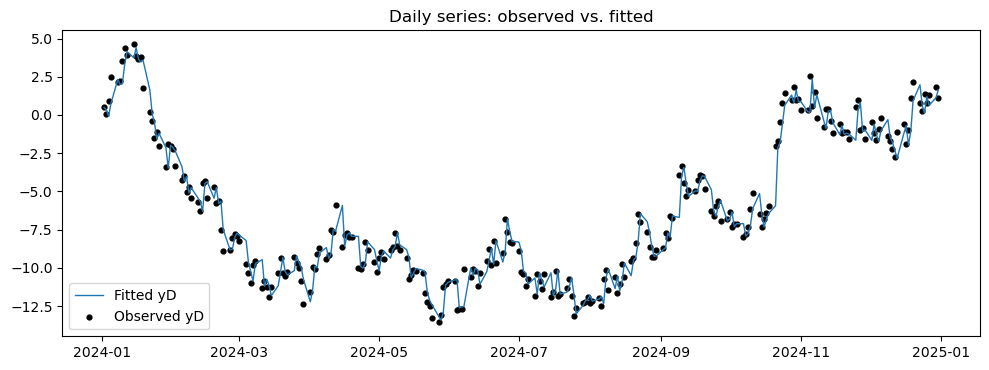

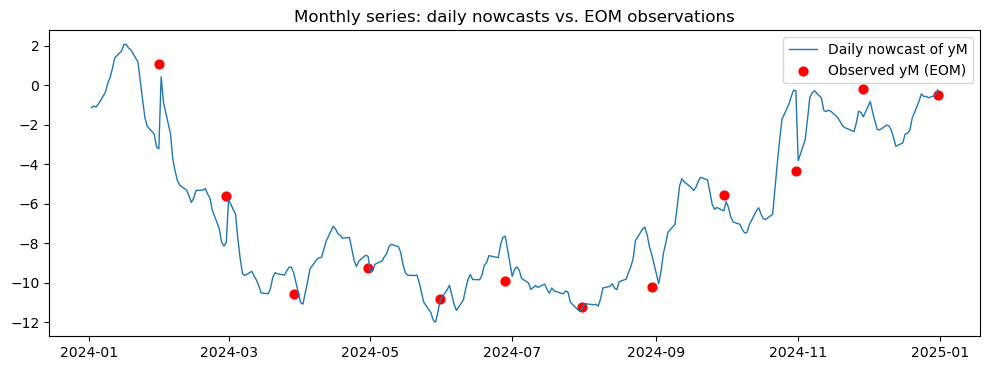


One-step-ahead forecast:
                  yD        yM
2025-01-01  0.954019 -0.440955


In [103]:
# ---------------------------------------------------------------------
#  DynamicFactorBizDM  ―  「営業日インデックス × 月次」専用ラッパ
# ---------------------------------------------------------------------
#  * statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ を継承
#  * インデックスは **営業日系列（freq='B' や JPX 営業日など）** に限定
#  * 週末・祝日を含む“カレンダー日”への再インデックスは **一切不要**
#
#  変更点はたった 2 か所
#    (1) コンストラクタ: k_endog_daily → k_endog_monthly にそのまま渡す
#    (2) _init_aggregation_matrices:
#        月次観測を「その月の営業日 N で平均」する Z_t を構築
#
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


class DynamicFactorBizDM(DynamicFactorMQ):
    """
    Dynamic Factor Mixed-Frequency (Daily(biz) ↔ Monthly).

    Parameters
    ----------
    endog : pd.DataFrame
        インデックスは営業日だけ。最初 k_endog_daily 列が日次観測、
        残りが月次観測（値は「月末営業日」にのみ入り、他は NaN）。
    k_endog_daily : int
        日次観測の列数。
    """

    # --- (1) コンストラクタ -----------------------------------------
    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int] = 1,
        factor_orders: int | list[int] = 1,
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # “高頻度”列として渡す
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # --- (2) 低頻度（月次）集計行列 Z_t を上書き --------------------
    def _init_aggregation_matrices(self):  # noqa: N802 (元メソッド名)
        idx = self._index                                # 営業日 DatetimeIndex
        T = len(idx)

        # 状態ベクトル長 L は既定 (=31) のまま利用
        k_states = self.ssm.k_states
        L = k_states // self.factors

        kD = self.k_endog_monthly                        # 日次列数
        kM = self.k_endog - kD                           # 月次列数
        pos_M = slice(kD, self.k_endog)                  # 月次行インデックス

        # デザイン行列 Z_t (k_endog × k_states × T)
        Z_t = np.zeros((self.k_endog, k_states, T))

        # ---- 日次パート: 当日ファクターをそのまま観測 ---------------
        for r in range(kD):
            Z_t[r, 0, :] = 1.0                           # lag 0

        # ---- 月次パート: 月末営業日だけ行をセット -------------------
        #  month_groups : {Period('2024-01', 'M'): [行番号, …], …}
        month_groups = idx.to_series().groupby(idx.to_period("M"))

        for per, positions in month_groups.groups.items():
            N = len(positions)                           # 当月の営業日数
            t_last = positions[-1]                       # 月末営業日の行
            row = np.zeros(k_states)
            row[:N] = 1.0 / N                            # 1/N 平均
            Z_t[pos_M, :, t_last] = np.tile(row, (kM, 1))

        # 既存 SSModel に注入
        self.ssm["design"] = Z_t

    # ------- 便利メソッド -------------------------------------------
    def fittedvalues_full(self) -> pd.DataFrame:
        """観測欠損を補完した in-sample フィット値"""
        return self._results.predict()

    def nowcast_lowfreq(self) -> pd.Series | pd.DataFrame:
        """月次列の営業日日次ナウキャスト"""
        fit = self._results.predict()
        return fit.iloc[:, self.k_endog_monthly:]


# ---------------------------------------------------------------------
#  デモ: 営業日インデックスのみで推定
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # 1. 営業日インデックスを作成（ここでは Mon-Fri = pandas freq 'B'）
    biz_idx = pd.bdate_range("2024-01-02", "2024-12-31")   # JP 祝日は無視

    # 2. 真の共通ファクター (ランダムウォーク) を営業日に合わせて生成
    np.random.seed(42)
    f_true = pd.Series(np.cumsum(np.random.randn(len(biz_idx))), index=biz_idx)

    # 3. 観測値を生成
    yD = f_true + 0.1 * np.random.randn(len(biz_idx))      # 日次列

    yM = pd.Series(index=biz_idx, dtype=float)
    for ts, mean_val in f_true.resample("M").mean().items():
        per = ts.to_period("M")                # Timestamp → Period[M]
        mask = biz_idx.to_period("M") == per   # 同じ型で比較
        if mask.any():
            last_bd = biz_idx[mask][-1]
            yM.loc[last_bd] = mean_val + 0.2 * np.random.randn()
            
    df = pd.DataFrame({"yD": yD, "yM": yM})

    # 4. モデル推定
    mod = DynamicFactorBizDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    # 5. フィット値と月次ナウキャスト
    fitted = res.predict()         # df と同じ形
    yM_nowcast = fitted["yM"]

    # 6. 可視化
    plt.figure(figsize=(10, 3.8))
    plt.plot(fitted["yD"], lw=1, label="Fitted yD")
    plt.scatter(df.index, df["yD"], s=12, c="k", label="Observed yD")
    plt.title("Daily series: observed vs. fitted"); plt.legend(); plt.tight_layout()

    plt.figure(figsize=(10, 3.8))
    plt.plot(yM_nowcast, lw=1, label="Daily nowcast of yM")
    plt.scatter(df.index[df["yM"].notna()],
                df.loc[df["yM"].notna(), "yM"],
                c="r", s=40, marker="o", label="Observed yM (EOM)")
    plt.title("Monthly series: daily nowcasts vs. EOM observations")
    plt.legend(); plt.tight_layout(); plt.show()

    # 7. 翌営業日の 1 ステップ先予測
    print("\nOne-step-ahead forecast:")
    print(res.forecast(steps=1))


In [102]:
df.head(30)

,yD,yM
2024-01-02,0.490762,NaN
2024-01-03,0.034323,NaN
2024-01-04,0.903700,NaN
2024-01-05,2.503911,NaN
2024-01-08,2.170237,NaN
2024-01-09,2.224119,NaN
2024-01-10,3.497077,NaN
2024-01-11,4.363521,NaN
2024-01-12,3.951125,NaN
2024-01-15,4.624738,NaN
